In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne

from mne.inverse_sparse import gamma_map, make_stc_from_dipoles
from mne.inverse_sparse.mxne_inverse import _make_sparse_stc
from mne.simulation import simulate_sparse_stc, simulate_evoked
from mne.viz import plot_sparse_source_estimates, plot_dipole_locations
from mne import convert_forward_solution
from mne.datasets import fetch_fsaverage, sample
from mne.viz import (
    plot_dipole_amplitudes,
    plot_dipole_locations,
    plot_sparse_source_estimates,
)

from scipy.spatial.distance import cdist
from ot import emd2


In [2]:
# The raw file containing the channel location and types
data_path = sample.data_path()
subject = "fsaverage"
subjects_dir = data_path / "subjects"

sample_dir = data_path / "MEG" / subject
# raw_fname = sample_dir / "sample_audvis_raw.fif"

In [3]:
# Constants
rng = np.random.RandomState(0)

sfreq = 150  # Sampling frequency in Hz
duration = 2 # 0.5  # Duration in seconds
tstep = 1.0 / sfreq  # Time step between samples
times = np.arange(0, duration, tstep)
n_times = len(times) # = int(sfreq * duration)  # Total number of time points

ch_type = 'eeg'

In [4]:
# handle events to create epochs to create evoked data (skipped for now)
nave = 20  # average of epochs
# event_interval = 200 # n_samples
# event_length = 0.5 # in seconds
# event_n_samples = event_length * sfreq
# n_events = duration//event_length

# events = np.zeros((n_events, 3), dtype=int)

# # events occur every 200 samples
# events[:, 0] = duration + event_interval * np.arange(n_events) 
# events[:, 2] = 1  # All events have the sample id.

In [5]:
montage = mne.channels.make_standard_montage("easycap-M43")
info = mne.create_info(montage.ch_names, sfreq=sfreq, ch_types=ch_type)
info.set_montage(montage);

In [6]:
# ico4: 1026 Sources per hemisphere, 9.9 Source spacing / mm
src = mne.setup_source_space(subject=subject, spacing='ico4', subjects_dir=subjects_dir);

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/orabe/0.braindata/MNE-sample-data/subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /Users/orabe/0.braindata/MNE-sample-data/subjects/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/orabe/0.braindata/MNE-sample-data/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading /Users/orabe/0.braindata/MNE-sample-data/subjects/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/orabe/0.braindata/MNE-sample-data/subjects/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded 

KeyboardInterrupt: 

In [11]:
mne.write_source_spaces('bsi_zoo/tests/data/my_ico4-src.fif', src, overwrite=True)

Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


In [6]:
src = mne.read_source_spaces('bsi_zoo/tests/data/my_ico4-src.fif')

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read


In [7]:
print('Number of sources:', src[0]['nuse'], src[1]['nuse'])
print('Location of the first source point (left hemisphere):', src[0]['rr'][0])
print('Orientation of the first source point (left hemisphere):', src[0]['nn'][0])
type(src)

Number of sources: 2562 2562
Location of the first source point (left hemisphere): [-0.03680628 -0.01829272  0.06446152]
Orientation of the first source point (left hemisphere): [-0.7392581 -0.5433783  0.3977908]


mne.source_space._source_space.SourceSpaces

In [8]:
model = mne.make_bem_model(subject=subject, ico=4, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.21 -19.38  -0.23 mm
outer skull CM is  -0.19 -19.34  -0.49 mm
inner skull CM is  -0.53 -21.10   6.21 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.6 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    5.4 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
     

In [9]:
sample_dir

PosixPath('/Users/orabe/0.braindata/MNE-sample-data/MEG/fsaverage')

In [10]:
# trans = sample_dir / "sample_audvis_raw-trans.fif"
fwd = mne.make_forward_solution(info,
                                # trans=trans,
                                trans='fsaverage',
                                src=src, 
                                bem=bem, 
                                eeg=True, 
                                meg=False)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=2562>, <surface (rh), n_vertices=163842, n_used=2562>] MRI (surface RAS) coords, subject 'fsaverage', ~28.3 MB>
MRI -> head transform : /Users/orabe/miniconda3/envs/mne/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of Con

In [11]:
leadfield = fwd["sol"]["data"]

print("Leadfield size : %d (channels) x %d (3*nsource)" % leadfield.shape)
assert leadfield.shape[1]//3 == fwd['nsource']

Leadfield size : 64 (channels) x 15372 (3*nsource)


In [12]:
fwd_src = fwd['src']
print('Number of sources:', fwd_src[0]['nuse'], fwd_src[1]['nuse'])
print('Location of the first source point (left hemisphere):', fwd_src[0]['rr'][0])
print('Orientation of the first source point (left hemisphere):', fwd_src[0]['nn'][0])
type(fwd_src)

Number of sources: 2562 2562
Location of the first source point (left hemisphere): [-0.03862072  0.01661226  0.10499121]
Orientation of the first source point (left hemisphere): [-0.74110298 -0.51734764  0.42792247]


mne.source_space._source_space.SourceSpaces

In [ ]:
vertices = [s['vertno'] for s in src] 
n_sources = sum(len(v) for v in vertices)
n_sources, vertices

(5124,
 [array([   0,    1,    2, ..., 2559, 2560, 2561]),
  array([   0,    1,    2, ..., 2559, 2560, 2561])])

In [14]:
print(f'fwd: nr sources in both him: {fwd["nsource"], fwd["nchan"]}')
print(f'fwd: sum of nr of sources in each him: {fwd_src[0]['nuse'] + fwd_src[1]['nuse']}')

fwd: nr sources in both him: (5124, 64)
fwd: sum of nr of sources in each him: 5124


#### Free orientation

In [70]:
L_free = fwd["sol"]["data"]
print(f"Leadfield size : {L_free.shape[0]} sensors x {L_free.shape[1]} dipoles")

Leadfield size : 64 sensors x 15372 dipoles


In [71]:
L_free = L_free.reshape(L_free.shape[0], -1, 3)
L_free.shape

(64, 5124, 3)

In [72]:
np.savez(f'bsi_zoo/tests/data/lead_field_free_{subject}.npz', lead_field=L_free, allow_pickle=True)

In [73]:
L_free = np.load(f'bsi_zoo/tests/data/lead_field_free_{subject}.npz')
print(L_free['lead_field'].shape)

(64, 5124, 3)


#### Fixed orientation

In [74]:
fwd_fixed = mne.convert_forward_solution(
    fwd, surf_ori=True, force_fixed=True, use_cps=True
)
L_fixed = fwd_fixed["sol"]["data"]

np.savez(f'bsi_zoo/tests/data/lead_field_{subject}.npz', lead_field=L_fixed, allow_pickle=True)

print(f"Leadfield size : {L_fixed.shape[0]} sensors x {L_fixed.shape[1]} dipoles")


    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 64 sensors x 5124 dipoles


In [75]:
L_fixed = np.load(f'bsi_zoo/tests/data/lead_field_{subject}.npz')
L_fixed['lead_field'].shape

(64, 5124)

(64, 5124, 3)

In [33]:
# fwd_fixed = mne.write_forward_solution(f'bsi_zoo/meta/fixed-{subject}-fwd.fif', fwd_fixed)


In [34]:
# fwd_fixed = mne.read_forward_solution(f'bsi_zoo/meta/fixed-{subject}-fwd.fif')

# Simulate the sparse source time courses (stc_sim)

In [13]:
# This function is from an mne tutorial and it is a fancy implementation of the data_func. We don't have to use this, we can just define a typical sinosiodal function.
# What it does is activating each dipole for short period of time and supress the other dipoles that we define in `n_dipoles`.
# I think this can help us to track back the estimated sources and see which and when each diple is active.

def data_fun(times):
    """Generate time-staggered sinusoids at harmonics of 10Hz."""
    global n
    window = np.zeros(n_times)
    start, stop = (
        int(ii * float(n_times) / (2 * n_dipoles)) for ii in (2 * n, 2 * n + 1)
    )
    window[start:stop] = 1.0
    n += 1
    data = 25e-9 * np.sin(2.0 * np.pi * 5.0 * n * times)
    data *= window
    return data


n = 0  # harmonic number
n_dipoles = 5

# Simulate the sparse source time courses
stc_sim = mne.simulation.simulate_sparse_stc(
    # src, n_dipoles=n_dipoles, times=times, data_fun=data_fun, random_state=rng
    src, n_dipoles=n_dipoles, times=times, data_fun=data_fun, random_state=rng

)

stc_sim.data.shape # dipoles x times

(5, 300)

In [14]:
print(stc_sim.vertices) # The indices of the dipoles in the left and right source space.
print(stc_sim.data[:len(stc_sim.vertices[0])].shape) # lh
print(stc_sim.data[-len(stc_sim.vertices[1]):].shape) # rh

[array([34152, 41604]), array([ 38820,  97454, 102532])]
(2, 300)
(3, 300)


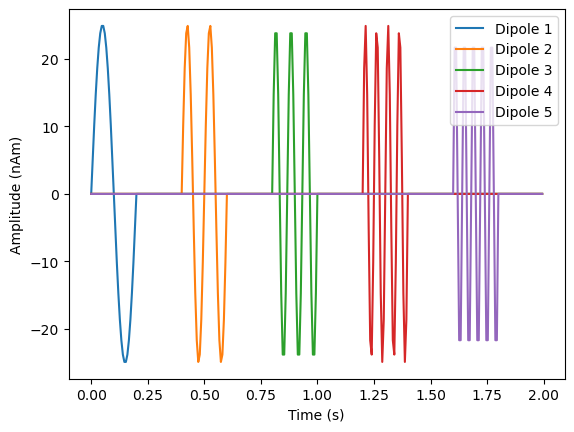

In [15]:
# Plot the stc_sim.data
fig, ax = plt.subplots(1)
for i in range(stc_sim.data.shape[0]):
    ax.plot(times, 1e9 * stc_sim.data[i, :], label=f'Dipole {i + 1}')
ax.set(ylabel="Amplitude (nAm)", xlabel="Time (s)")
ax.legend()
mne.viz.utils.plt_show()

## Evoke the stc_sim

In [16]:
evoked_sim = simulate_evoked(fwd,
                             stc_sim,
                             info,
                             cov=None, 
                             nave=nave, 
                             iir_filter=None,
                             random_state=rng,
                             use_cps=True,
                             verbose=True)
evoked_sim.data.shape

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Projecting source estimate to sensor space...
[done]


(64, 300)

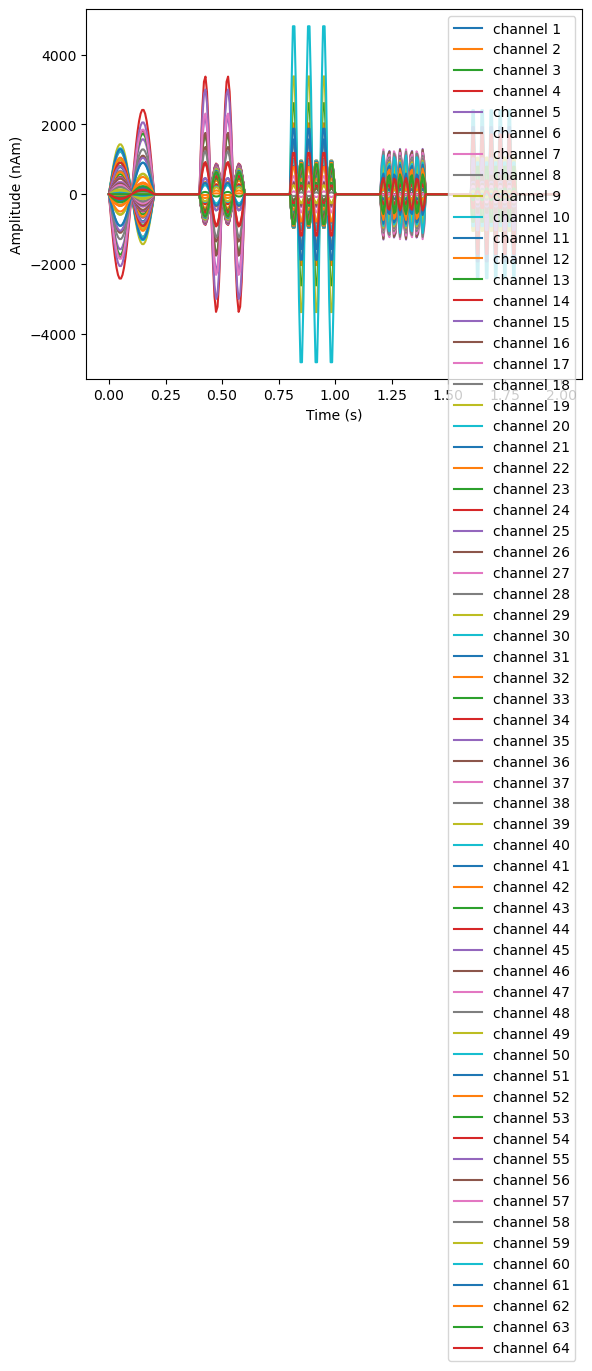

In [17]:
# Plot the evoked_stc_sim
fig, ax = plt.subplots(1)
for i in range(evoked_sim.data.shape[0]):
    ax.plot(times, 1e9 * evoked_sim.data[i, :], label=f'channel {i + 1}')
ax.set(ylabel="Amplitude (nAm)", xlabel="Time (s)")
ax.legend()
mne.viz.utils.plt_show()

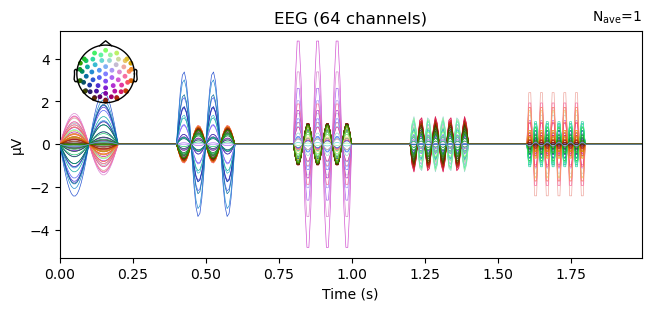

In [18]:
evoked_sim.plot(time_unit="s");


In [19]:
# Create an ad-hoc covariance matrix
cov = mne.make_ad_hoc_cov(evoked_sim.info)
mne.simulation.add_noise(evoked_sim,
                         cov, 
                         iir_filter=[0.2, -0.2, 0.04], 
                         random_state=rng)

Adding noise to 64/64 channels (64 channels in cov)


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_50550/2807341053.py:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  mne.simulation.add_noise(evoked_sim,


<Evoked | '' (average, N=1), 0 – 1.9933 s, baseline off, 64 ch, ~225 kB>

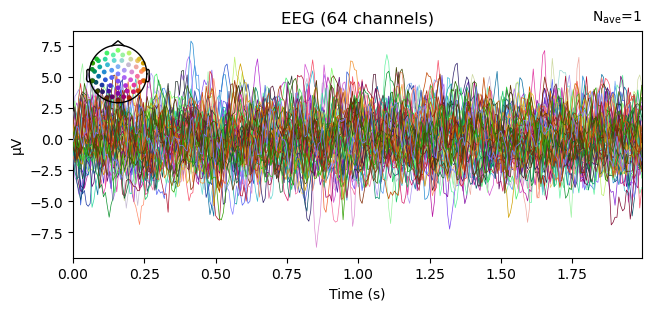

In [20]:
evoked_sim.plot(time_unit="s");

# Solve the inverse problem with Gamma-MAP

In [21]:
print(evoked_sim.data.shape) # (n_channels, times)
print(fwd['sol']['data'].shape) # (n_channels, nsource * n_ori)
print(fwd['sol']['data'].shape[1]//3) # (nsource)

print(fwd['src'][0]['nuse'], fwd['src'][1]['nuse'])
print(fwd['nsource'], fwd['sol']['data'].shape[1]//3)

cov.data.shape # n_chs

(64, 300)
(64, 3846)
1282
641 641
1282 1282


(64,)

In [41]:
from _gamma_map import gamma_map as my_gamma_map


# Run Gamma-MAP method with dipole output
evoked_sim.set_eeg_reference(projection=True)
alpha = 0.5 # Regularization parameter (noise variance).
# dipoles_rec, residual, posterior_cov 
dipoles_rec, residual, posterior_cov = my_gamma_map(evoked_sim,
                              fwd, 
                              cov, 
                              alpha, 
                              loose=0, # If 0, then the solution is computed with fixed orientation. If 1, it corresponds to free orientations.
                              xyz_same_gamma=True, 
                              return_residual=True,
                              return_as_dipoles=True)

EEG channel type selected for re-referencing


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_50550/2473920929.py:5: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked_sim.set_eeg_reference(projection=True)


Converting forward solution to fixed orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 5.7e-18 (2.2e-16 eps * 64 dim * 0.0004  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Whitening data matrix.
Iteration: 0	 active set size: 1282	 convergence: 1.651e+01
Iteration: 25	 active set size: 1279	 convergence: 4.172e-03
Iteration: 26	 active set size: 1276	 convergence: 4.038e-

In [23]:
posterior_cov.shape

(88, 88)

In [24]:
# # Run Gamma-MAP method with dipole output
# evoked_sim.set_eeg_reference(projection=True)
# alpha = 0.5 # Regularization parameter (noise variance).
# dipoles_rec, residual = gamma_map(evoked_sim,
#                               fwd, 
#                               cov, 
#                               alpha, 
#                               loose=0, # If 0, then the solution is computed with fixed orientation. If 1, it corresponds to free orientations.
#                               xyz_same_gamma=True, 
#                               return_residual=True,
#                               return_as_dipoles=True)

In [25]:
len(dipoles_rec)

88

In [26]:
# Create stc_rec object from the estimated dipoles
stc_rec = make_stc_from_dipoles(dipoles_rec, fwd['src'])

Converting dipoles into a SourceEstimate.
[done]


In [27]:
print(stc_sim.data.shape) # dipoles x times
print(stc_rec.data.shape) # dipoles x times

(5, 300)
(88, 300)


In [28]:
print(stc_rec.data[:len(stc_rec.vertices[0])].shape) # lh
print(stc_rec.data[-len(stc_rec.vertices[1]):].shape) # rh

(36, 300)
(52, 300)


Using pyvistaqt 3d backend.
Total number of active sources: [ 34152  41604 194227 252861 257939]


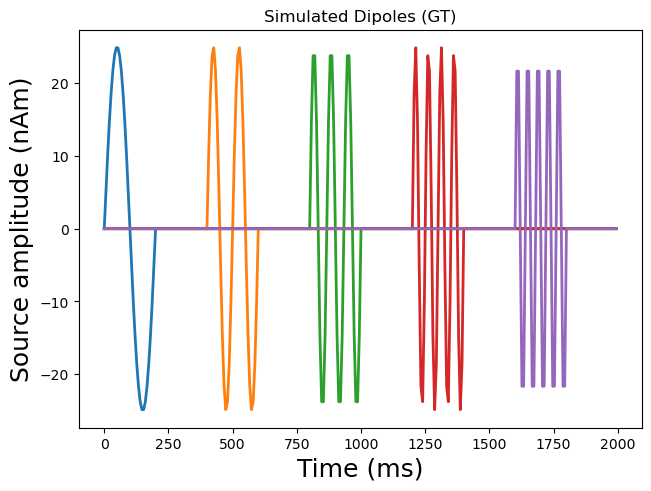

Total number of active sources: [  1235   5843   7638   9996  11624  20690  23190  26685  28158  28371
  46926  50846  54771  64704  68279  74547  78235  78365  78370  86911
  95337  95926  96710 102963 103068 103717 106906 111146 112802 113203
 116427 116974 119517 123298 143681 150801 157331 158179 161761 161839
 166973 170131 172873 174402 180189 181006 185971 187522 187682 196899
 204491 205260 205657 209825 210151 210419 213039 218137 222210 224733
 229873 234794 235010 237766 240085 241224 242842 243653 248519 252006
 254938 256195 264987 273400 275572 277233 280123 282097 285524 291100
 291203 291988 296657 296781 297602 301106 311360 312248]


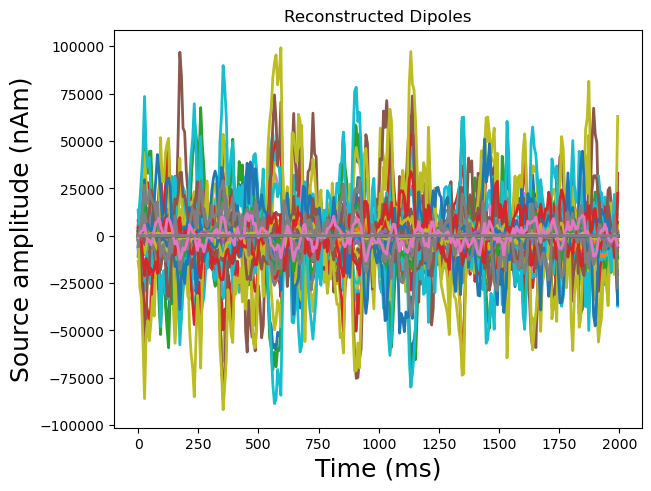

In [29]:
plot_sparse_source_estimates(fwd['src'],
                             stc_sim, 
                             bgcolor=(1, 1, 1), 
                             fig_name="Simulated Dipoles (GT)")

plot_sparse_source_estimates(fwd['src'], 
                             stc_rec, 
                             bgcolor=(1, 1, 1), 
                             fig_name="Reconstructed Dipoles")

In [30]:
# Plot estimated dipole locations on a 3D brain model
# plot_dipole_locations(dipoles_rec, 
#                       trans=trans,
#                       subject='sample',
#                       subjects_dir=subjects_dir, 
#                       mode='orthoview',
#                       coord_frame='mri',
#                       idx='amplitude');

# Plot estimated dipole amplitudes over time
# plot_dipole_amplitudes(dipoles_rec,
#                        colors=None,
#                        show=True);

In [31]:
# Calculate mean (over time) absolute amplitudes for each dipole 
mean_absolute_amplitudes = [np.mean(np.abs(dipole.amplitude)) for dipole in dipoles_rec]

# Find the indices of the dipoles with the highest amplitudes
prominent_indices = np.argsort(mean_absolute_amplitudes)[-5:]  # Top 5 dipoles

# Extract the top dipoles
prominent_dipoles = [dipoles_rec[i] for i in prominent_indices]

# extract their positions
dipole_positions = [dipole.pos for dipole in prominent_dipoles] 

# print pos of top 5 dipols (xyz)
for i in range(5):
    print(dipole_positions[i][0])
    
prominent_indices


[-0.04426465  0.02216519  0.01363216]
[-0.0471746  -0.00732821  0.03554892]
[ 0.03143558 -0.0244154   0.0504298 ]
[ 0.01108438 -0.00711103  0.0542917 ]
[ 0.02468841 -0.01441802  0.04856279]


array([32, 18, 55, 59, 58])

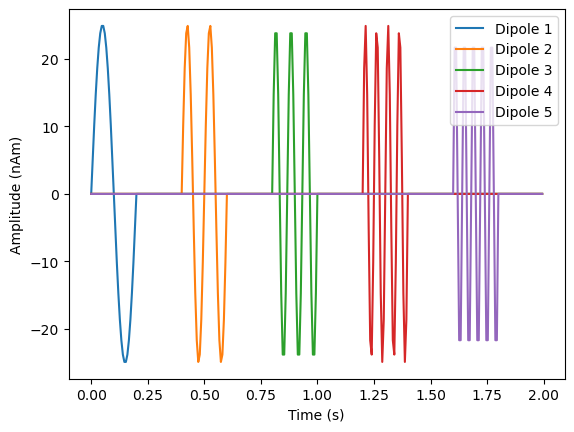

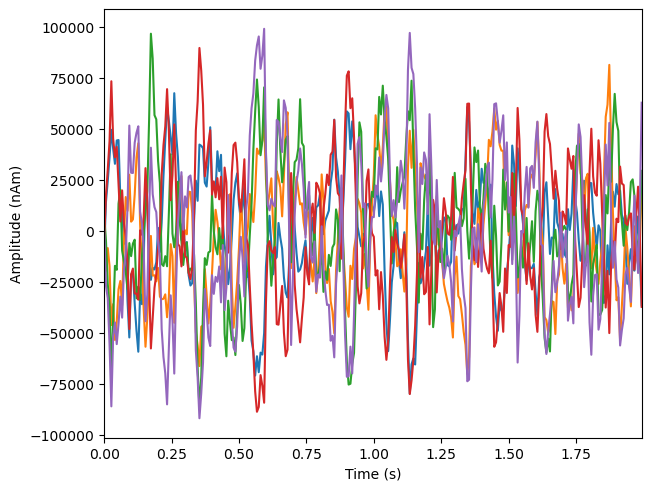

In [32]:
fig, ax = plt.subplots(1)
for i in range(stc_sim.data.shape[0]):
    ax.plot(times, 1e9 * stc_sim.data[i, :], label=f'Dipole {i + 1}')
ax.set(ylabel="Amplitude (nAm)", xlabel="Time (s)")
ax.legend()
mne.viz.utils.plt_show()

# Plot top dipole amplitudes
plot_dipole_amplitudes(prominent_dipoles,
                       colors=None,
                       show=True);

In [33]:
# Sort dipoles by the norm of their amplitude (for vector dipoles)
sorted_dipoles = sorted(dipoles_rec,
                        key=lambda d: np.linalg.norm(d.amplitude), 
                        reverse=True)

# Extract the top contributing dipoles (e.g., top 5 dipoles)
top_dipoles = sorted_dipoles[:5]
top_dipole_positions = [dipole.pos for dipole in top_dipoles]  

# print pos of top 5 dipols (xyz)
for i in range(5):
    print(top_dipole_positions[i][0])

[ 0.02468841 -0.01441802  0.04856279]
[ 0.01108438 -0.00711103  0.0542917 ]
[ 0.03143558 -0.0244154   0.0504298 ]
[-0.0471746  -0.00732821  0.03554892]
[-0.04426465  0.02216519  0.01363216]


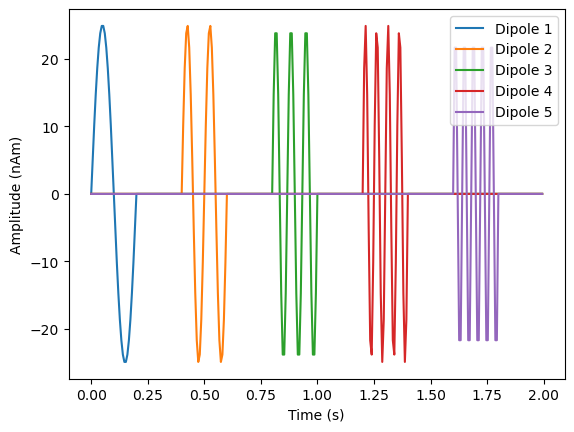

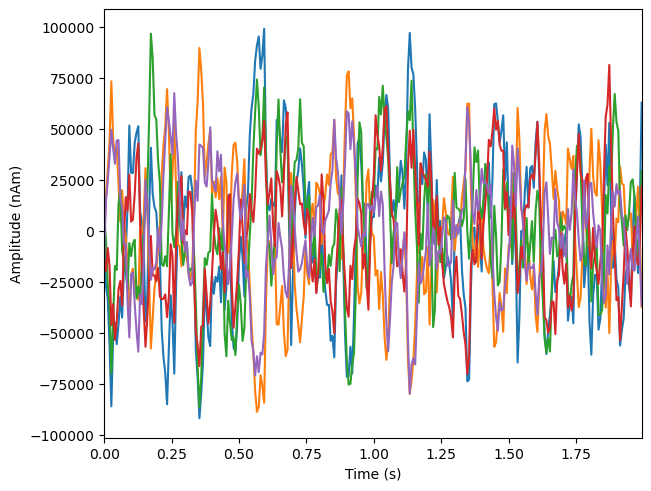

In [34]:
fig, ax = plt.subplots(1)
for i in range(stc_sim.data.shape[0]):
    ax.plot(times, 1e9 * stc_sim.data[i, :], label=f'Dipole {i + 1}')
ax.set(ylabel="Amplitude (nAm)", xlabel="Time (s)")
ax.legend()
mne.viz.utils.plt_show()

# Plot top dipole amplitudes
plot_dipole_amplitudes(top_dipoles,
                       colors=None,
                       show=True);

# 1

Total number of active sources: [ 34152  41604 194227 252861 257939]


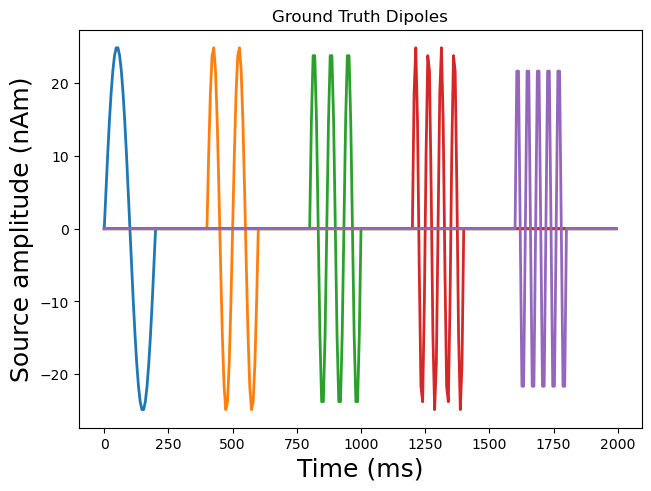

Total number of active sources: [  1235   5843   7638   9996  11624  20690  23190  26685  28158  28371
  46926  50846  54771  64704  68279  74547  78235  78365  78370  86911
  95337  95926  96710 102963 103068 103717 106906 111146 112802 113203
 116427 116974 119517 123298 143681 150801 157331 158179 161761 161839
 166973 170131 172873 174402 180189 181006 185971 187522 187682 196899
 204491 205260 205657 209825 210151 210419 213039 218137 222210 224733
 229873 234794 235010 237766 240085 241224 242842 243653 248519 252006
 254938 256195 264987 273400 275572 277233 280123 282097 285524 291100
 291203 291988 296657 296781 297602 301106 311360 312248]


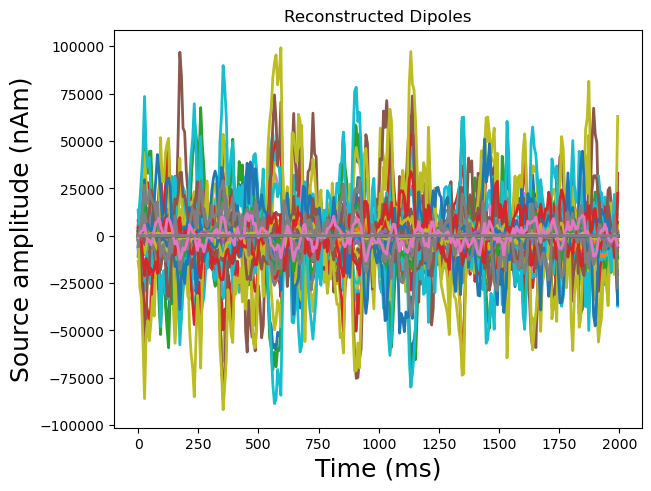

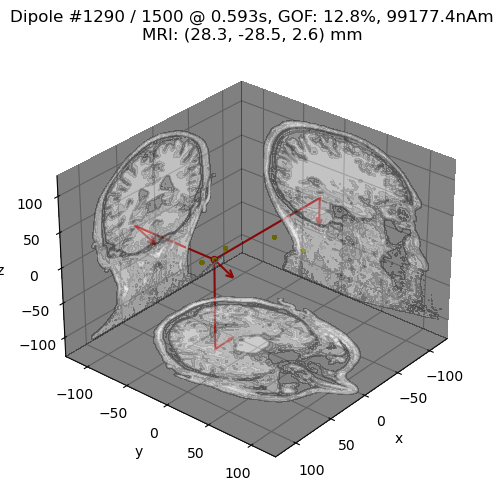

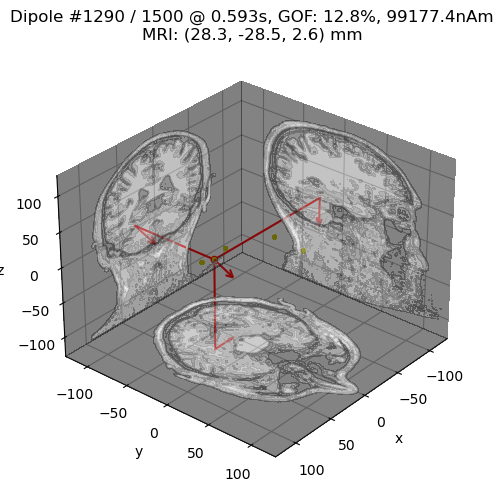

In [35]:

def emd(x, x_hat, orientation_type, subject, fwd, *args, **kwargs):
    """
    Calculate the Earth Mover's Distance (EMD) between ground truth (x) and
    reconstructed sources (x_hat).
    
    Parameters:
    x : array
        Ground truth source time courses.
    x_hat : array
        Reconstructed source time courses.
    orientation_type : str
        Either 'fixed' or 'free' depending on the orientation type.
    subject : str
        Subject identifier.
    fwd : dict
        Forward solution structure (includes source space).
    
    Returns:
    float
        The squared Earth Mover's Distance (EMD2).
    """
    
    # Different handling for 'fixed' vs 'free' orientations
    if orientation_type == "fixed":
        temp = np.linalg.norm(x, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
        
    elif orientation_type == "free":
        temp = np.linalg.norm(x, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
    
    # Convert the forward solution to 'fixed' orientation for the EMD calculation
    fwd_fixed = convert_forward_solution(fwd, force_fixed=True)
    src = fwd_fixed["src"]

    # Create sparse STCs for both ground truth and reconstructed sources
    stc_a = _make_sparse_stc(a[:, None], a_mask, fwd_fixed, tmin=1, tstep=1)
    stc_b = _make_sparse_stc(b[:, None], b_mask, fwd_fixed, tmin=1, tstep=1)

    # Extract the 3D coordinates (rr) for the dipoles in both ground truth and reconstructed sources
    rr_a = np.r_[src[0]["rr"][stc_a.lh_vertno], src[1]["rr"][stc_a.rh_vertno]]
    rr_b = np.r_[src[0]["rr"][stc_b.lh_vertno], src[1]["rr"][stc_b.rh_vertno]]

    # Calculate the Euclidean distance matrix (M) between ground truth and reconstructed dipoles
    M = cdist(rr_a, rr_b, metric="euclidean")

    # Normalize the amplitudes 'a' and 'b' to sum to 1 (required for EMD)
    a /= a.sum()
    b /= b.sum()

    # Calculate and return the squared Earth Mover's Distance (EMD2)
    return emd2(a, b, M)

# Visualize ground truth dipoles
plot_sparse_source_estimates(fwd['src'],
                             stc_sim,
                             bgcolor=(1, 1, 1),
                             fig_name="Ground Truth Dipoles")

# Visualize reconstructed dipoles
plot_sparse_source_estimates(fwd['src'],
                             stc_rec,
                             bgcolor=(1, 1, 1),
                             fig_name="Reconstructed Dipoles")

# Visualize top dipoles (e.g., the ones with the highest amplitudes)
plot_dipole_locations(prominent_dipoles,
                      trans=trans,
                      subject='sample',
                      subjects_dir=subjects_dir,
                      mode='orthoview',
                      coord_frame='mri',
                      idx='amplitude')




In [36]:
# Convert the forward solution to a fixed orientation
# fwd_fixed = convert_forward_solution(fwd, force_fixed=True)

# Continue with your EMD function or other code
emd2_value = emd(stc_sim.data,
                 stc_rec.data,
                 "fixed",
                 subject,
                 fwd)

# Print the result
print(f"EMD2 between ground truth and reconstructed dipoles: {emd2_value}")

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
EMD2 between ground truth and reconstructed dipoles: 0.024629191047635685


# 2

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
EMD2 between ground truth and reconstructed dipoles: 0.024629191047635685


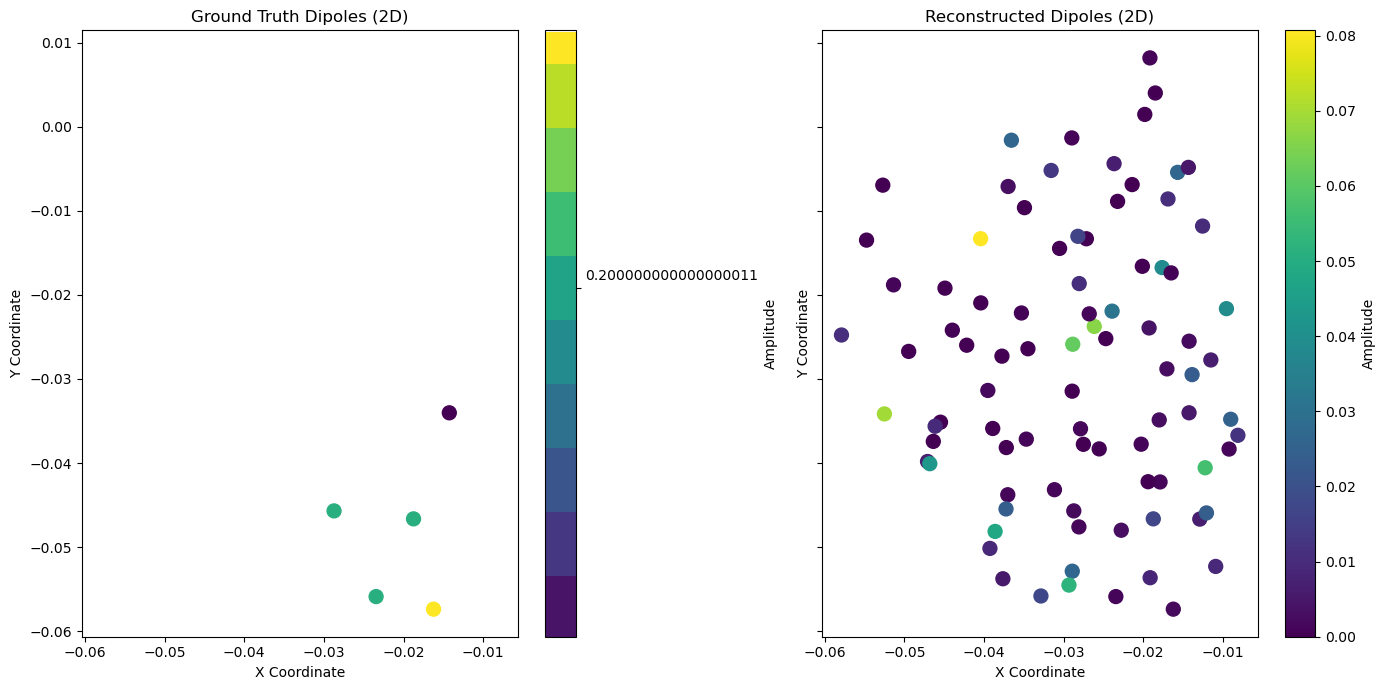

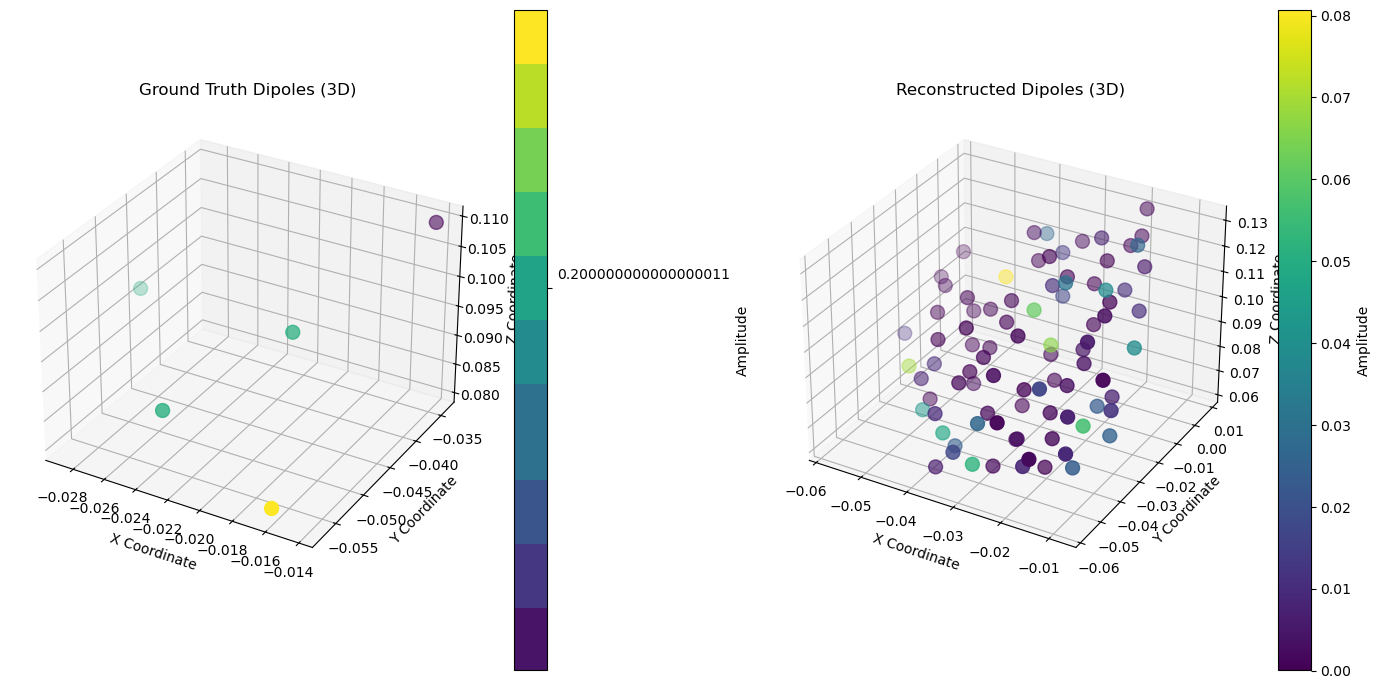

In [37]:
def emd(x, x_hat, orientation_type, subject, fwd, *args, **kwargs):
    """
    Calculate the Earth Mover's Distance (EMD) between ground truth (x) and
    reconstructed sources (x_hat).
    
    Parameters:
    x : array
        Ground truth source time courses.
    x_hat : array
        Reconstructed source time courses.
    orientation_type : str
        Either 'fixed' or 'free' depending on the orientation type.
    subject : str
        Subject identifier.
    fwd : dict
        Forward solution structure (includes source space).
    
    Returns:
    float
        The squared Earth Mover's Distance (EMD2).
    """
    
    # Different handling for 'fixed' vs 'free' orientations
    if orientation_type == "fixed":
        temp = np.linalg.norm(x, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
        
    elif orientation_type == "free":
        temp = np.linalg.norm(x, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
    
    # Convert the forward solution to 'fixed' orientation for the EMD calculation
    fwd_fixed = convert_forward_solution(fwd, force_fixed=True)
    src = fwd_fixed["src"]

    # Create sparse STCs for both ground truth and reconstructed sources
    stc_a = _make_sparse_stc(a[:, None], a_mask, fwd_fixed, tmin=1, tstep=1)
    stc_b = _make_sparse_stc(b[:, None], b_mask, fwd_fixed, tmin=1, tstep=1)

    # Extract the 3D coordinates (rr) for the dipoles in both ground truth and reconstructed sources
    rr_a = np.r_[src[0]["rr"][stc_a.lh_vertno], src[1]["rr"][stc_a.rh_vertno]]
    rr_b = np.r_[src[0]["rr"][stc_b.lh_vertno], src[1]["rr"][stc_b.rh_vertno]]

    # Calculate the Euclidean distance matrix (M) between ground truth and reconstructed dipoles
    M = cdist(rr_a, rr_b, metric="euclidean")

    # Normalize the amplitudes 'a' and 'b' to sum to 1 (required for EMD)
    a /= a.sum()
    b /= b.sum()

    # Calculate and return the squared Earth Mover's Distance (EMD2)
    return emd2(a, b, M), rr_a, rr_b, a, b

def plot_comparison_2d_and_3d(rr_a, rr_b, a, b):
    """
    Plot the comparison of ground truth and reconstructed dipoles in 2D and 3D.
    
    Parameters:
    rr_a : array
        3D coordinates of the top dipoles from ground truth.
    rr_b : array
        3D coordinates of the top dipoles from reconstructed sources.
    a : array
        Amplitudes of the top dipoles from ground truth.
    b : array
        Amplitudes of the top dipoles from reconstructed sources.
    """
    # 2D Plot (projected onto XY plane)
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

    # Plot ground truth dipoles in 2D
    sc1 = ax[0].scatter(rr_a[:, 0], rr_a[:, 1], c=a, s=100, cmap='viridis', label='Ground Truth')
    ax[0].set_title('Ground Truth Dipoles (2D)')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    fig.colorbar(sc1, ax=ax[0], label='Amplitude')

    # Plot reconstructed dipoles in 2D
    sc2 = ax[1].scatter(rr_b[:, 0], rr_b[:, 1], c=b, s=100, cmap='viridis', label='Reconstructed')
    ax[1].set_title('Reconstructed Dipoles (2D)')
    ax[1].set_xlabel('X Coordinate')
    ax[1].set_ylabel('Y Coordinate')
    fig.colorbar(sc2, ax=ax[1], label='Amplitude')

    plt.tight_layout()
    plt.show()

    # 3D Plot
    fig = plt.figure(figsize=(14, 7))

    # Plot ground truth dipoles in 3D
    ax1 = fig.add_subplot(121, projection='3d')
    sc1 = ax1.scatter(rr_a[:, 0], rr_a[:, 1], rr_a[:, 2], c=a, s=100, cmap='viridis', label='Ground Truth')
    ax1.set_title('Ground Truth Dipoles (3D)')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.set_zlabel('Z Coordinate')
    fig.colorbar(sc1, ax=ax1, label='Amplitude')

    # Plot reconstructed dipoles in 3D
    ax2 = fig.add_subplot(122, projection='3d')
    sc2 = ax2.scatter(rr_b[:, 0], rr_b[:, 1], rr_b[:, 2], c=b, s=100, cmap='viridis', label='Reconstructed')
    ax2.set_title('Reconstructed Dipoles (3D)')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_zlabel('Z Coordinate')
    fig.colorbar(sc2, ax=ax2, label='Amplitude')

    plt.tight_layout()
    plt.show()

# Example usage
fwd_fixed = convert_forward_solution(fwd, force_fixed=True)

# Calculate the EMD2 and retrieve dipole information
emd2_value, rr_a, rr_b, a, b = emd(
    stc_sim.data,
    stc_rec.data,
    "fixed",
    subject,
    fwd_fixed
)

# Print the result
print(f"EMD2 between ground truth and reconstructed dipoles: {emd2_value}")

# Plot the comparison in 2D and 3D
plot_comparison_2d_and_3d(rr_a, rr_b, a, b)




# 3

In [38]:



def emd(x, x_hat, orientation_type, subject, fwd, *args, **kwargs):
    """
    Calculate the Earth Mover's Distance (EMD) between ground truth (x) and
    reconstructed sources (x_hat).
    
    Parameters:
    x : array
        Ground truth source time courses.
    x_hat : array
        Reconstructed source time courses.
    orientation_type : str
        Either 'fixed' or 'free' depending on the orientation type.
    subject : str
        Subject identifier.
    fwd : dict
        Forward solution structure (includes source space).
    
    Returns:
    float
        The squared Earth Mover's Distance (EMD2).
    """
    
    # Different handling for 'fixed' vs 'free' orientations
    if orientation_type == "fixed":
        temp = np.linalg.norm(x, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
        
    elif orientation_type == "free":
        temp = np.linalg.norm(x, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
    
    # Sort by amplitude and take the top 4 dipoles
    top_indices_ground_truth = np.argsort(-a)[:4]  # Top 4 ground truth dipoles
    top_indices_reconstructed = np.argsort(-b)[:4]  # Top 4 reconstructed dipoles

    a = a[top_indices_ground_truth]
    b = b[top_indices_reconstructed]

    # Extract positions of the top 4 dipoles for ground truth and reconstructed
    dipole_positions_ground_truth = fwd['src'][0]['rr'][top_indices_ground_truth]
    dipole_positions_reconstructed = fwd['src'][0]['rr'][top_indices_reconstructed]

    # Calculate the Euclidean distance matrix (M) between the top dipoles
    M = cdist(dipole_positions_ground_truth, dipole_positions_reconstructed, metric="euclidean")

    # Normalize the amplitudes 'a' and 'b' to sum to 1 (required for EMD)
    a /= a.sum()
    b /= b.sum()

    # Calculate and return the squared Earth Mover's Distance (EMD2)
    return emd2(a, b, M)

# Example usage
fwd_fixed = convert_forward_solution(fwd, force_fixed=True)

# Calculate the EMD2 between ground truth and reconstructed top 4 dipoles
emd2_value = emd(stc_sim.data,
                 stc_rec.data,
                 "fixed",
                 subject,
                 fwd_fixed)

# Print the result
print(f"EMD2 between ground truth and reconstructed dipoles: {emd2_value}")


    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...


    [done]
EMD2 between ground truth and reconstructed dipoles: 0.004102146216227665


# 4

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
EMD2 between ground truth and reconstructed dipoles: 0.004102146216227665


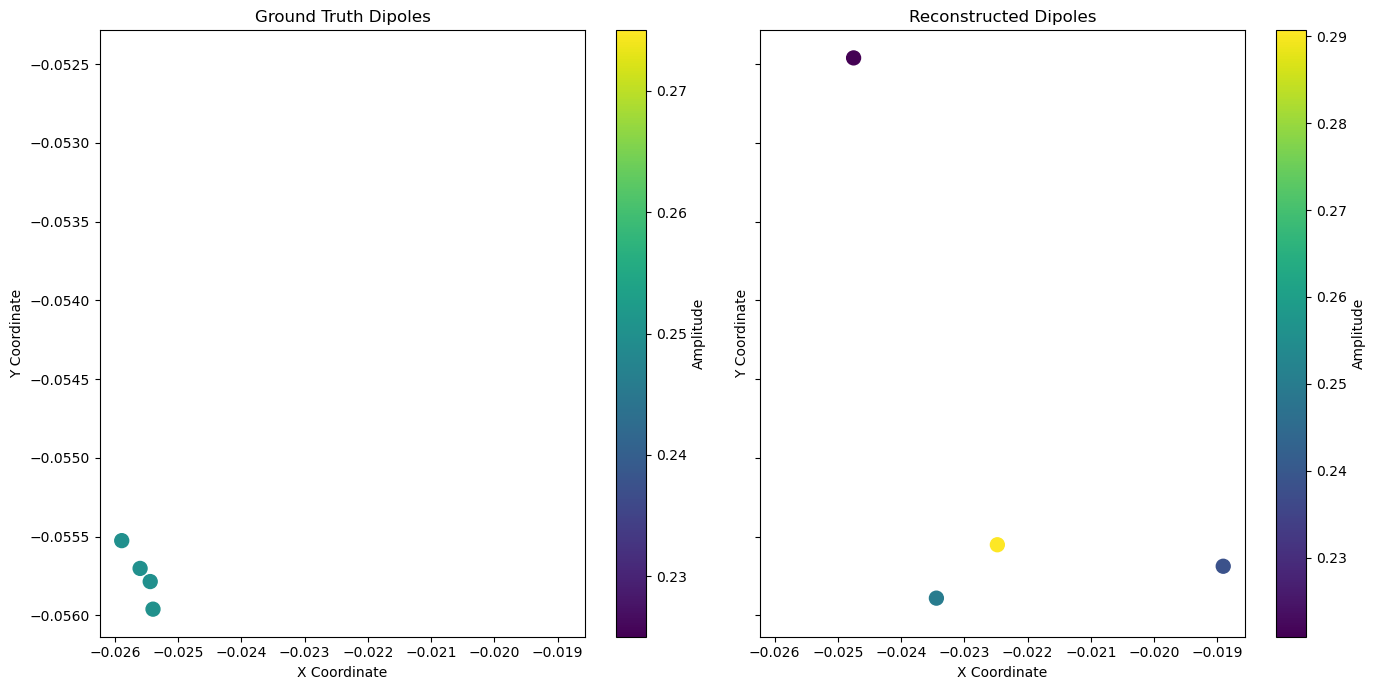

In [39]:

def emd(x, x_hat, orientation_type, subject, fwd, *args, **kwargs):
    """
    Calculate the Earth Mover's Distance (EMD) between ground truth (x) and
    reconstructed sources (x_hat).
    
    Parameters:
    x : array
        Ground truth source time courses.
    x_hat : array
        Reconstructed source time courses.
    orientation_type : str
        Either 'fixed' or 'free' depending on the orientation type.
    subject : str
        Subject identifier.
    fwd : dict
        Forward solution structure (includes source space).
    
    Returns:
    float
        The squared Earth Mover's Distance (EMD2).
    """
    
    # Different handling for 'fixed' vs 'free' orientations
    if orientation_type == "fixed":
        temp = np.linalg.norm(x, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
        
    elif orientation_type == "free":
        temp = np.linalg.norm(x, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
    
    # Sort by amplitude and take the top 4 dipoles
    top_indices_ground_truth = np.argsort(-a)[:4]  # Top 4 ground truth dipoles
    top_indices_reconstructed = np.argsort(-b)[:4]  # Top 4 reconstructed dipoles

    a = a[top_indices_ground_truth]
    b = b[top_indices_reconstructed]

    # Extract positions of the top 4 dipoles for ground truth and reconstructed
    dipole_positions_ground_truth = fwd['src'][0]['rr'][top_indices_ground_truth]
    dipole_positions_reconstructed = fwd['src'][0]['rr'][top_indices_reconstructed]

    # Calculate the Euclidean distance matrix (M) between the top dipoles
    M = cdist(dipole_positions_ground_truth, dipole_positions_reconstructed, metric="euclidean")

    # Normalize the amplitudes 'a' and 'b' to sum to 1 (required for EMD)
    a /= a.sum()
    b /= b.sum()

    # Calculate and return the squared Earth Mover's Distance (EMD2)
    return emd2(a, b, M), dipole_positions_ground_truth, dipole_positions_reconstructed, a, b

def plot_comparison(dipole_positions_ground_truth, dipole_positions_reconstructed, a, b):
    """
    Plot the comparison of top dipoles from ground truth and reconstructed sources.
    
    Parameters:
    dipole_positions_ground_truth : array
        Positions of the top dipoles from ground truth.
    dipole_positions_reconstructed : array
        Positions of the top dipoles from reconstructed sources.
    a : array
        Amplitudes of the top dipoles from ground truth.
    b : array
        Amplitudes of the top dipoles from reconstructed sources.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex= True, sharey=True)
    
    # Plot ground truth dipoles
    sc1 = ax[0].scatter(dipole_positions_ground_truth[:, 0], dipole_positions_ground_truth[:, 1], 
                        c=a, s=100, cmap='viridis', label='Ground Truth')
    ax[0].set_title('Ground Truth Dipoles')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    fig.colorbar(sc1, ax=ax[0], label='Amplitude')
    
    # Plot reconstructed dipoles
    sc2 = ax[1].scatter(dipole_positions_reconstructed[:, 0], dipole_positions_reconstructed[:, 1], 
                        c=b, s=100, cmap='viridis', label='Reconstructed')
    ax[1].set_title('Reconstructed Dipoles')
    ax[1].set_xlabel('X Coordinate')
    ax[1].set_ylabel('Y Coordinate')
    fig.colorbar(sc2, ax=ax[1], label='Amplitude')
    
    plt.tight_layout()
    plt.show()

# Example usage
fwd_fixed = convert_forward_solution(fwd, force_fixed=True)

# Calculate the EMD2 and retrieve dipole information
emd2_value, dipole_positions_ground_truth, dipole_positions_reconstructed, a, b = emd(
    stc_sim.data,
    stc_rec.data,
    "fixed",
    subject,
    fwd_fixed
)

# Print the result
print(f"EMD2 between ground truth and reconstructed dipoles: {emd2_value}")

# Plot the comparison
plot_comparison(dipole_positions_ground_truth, dipole_positions_reconstructed, a, b)



# 5

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
EMD2 between ground truth and reconstructed dipoles: 0.004102146216227665


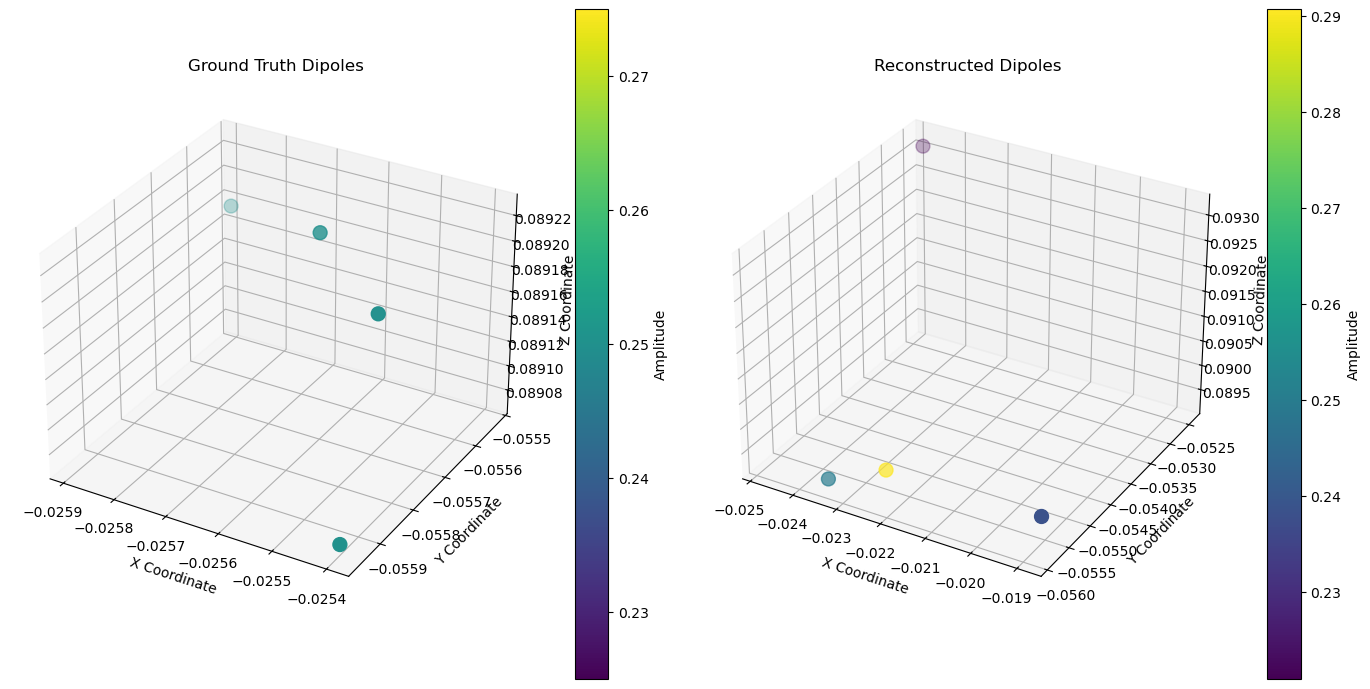

In [40]:
def emd(x, x_hat, orientation_type, subject, fwd, *args, **kwargs):
    """
    Calculate the Earth Mover's Distance (EMD) between ground truth (x) and
    reconstructed sources (x_hat).
    
    Parameters:
    x : array
        Ground truth source time courses.
    x_hat : array
        Reconstructed source time courses.
    orientation_type : str
        Either 'fixed' or 'free' depending on the orientation type.
    subject : str
        Subject identifier.
    fwd : dict
        Forward solution structure (includes source space).
    
    Returns:
    float
        The squared Earth Mover's Distance (EMD2).
    """
    
    # Different handling for 'fixed' vs 'free' orientations
    if orientation_type == "fixed":
        temp = np.linalg.norm(x, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
        
    elif orientation_type == "free":
        temp = np.linalg.norm(x, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        a_mask = temp != 0
        a = temp[a_mask]

        temp = np.linalg.norm(x_hat, axis=2)
        temp = np.linalg.norm(temp, axis=1)
        b_mask = temp != 0
        b = temp[b_mask]
    
    # Sort by amplitude and take the top 4 dipoles
    top_indices_ground_truth = np.argsort(-a)[:4]  # Top 4 ground truth dipoles
    top_indices_reconstructed = np.argsort(-b)[:4]  # Top 4 reconstructed dipoles

    a = a[top_indices_ground_truth]
    b = b[top_indices_reconstructed]

    # Extract positions of the top 4 dipoles for ground truth and reconstructed
    dipole_positions_ground_truth = fwd['src'][0]['rr'][top_indices_ground_truth]
    dipole_positions_reconstructed = fwd['src'][0]['rr'][top_indices_reconstructed]

    # Calculate the Euclidean distance matrix (M) between the top dipoles
    M = cdist(dipole_positions_ground_truth, dipole_positions_reconstructed, metric="euclidean")

    # Normalize the amplitudes 'a' and 'b' to sum to 1 (required for EMD)
    a /= a.sum()
    b /= b.sum()

    # Calculate and return the squared Earth Mover's Distance (EMD2)
    return emd2(a, b, M), dipole_positions_ground_truth, dipole_positions_reconstructed, a, b

def plot_comparison_3d(dipole_positions_ground_truth, dipole_positions_reconstructed, a, b):
    """
    Plot the comparison of top dipoles from ground truth and reconstructed sources in 3D.
    
    Parameters:
    dipole_positions_ground_truth : array
        Positions of the top dipoles from ground truth.
    dipole_positions_reconstructed : array
        Positions of the top dipoles from reconstructed sources.
    a : array
        Amplitudes of the top dipoles from ground truth.
    b : array
        Amplitudes of the top dipoles from reconstructed sources.
    """
    fig = plt.figure(figsize=(14, 7))
    
    # Plot ground truth dipoles
    ax1 = fig.add_subplot(121, projection='3d')
    sc1 = ax1.scatter(dipole_positions_ground_truth[:, 0], dipole_positions_ground_truth[:, 1], dipole_positions_ground_truth[:, 2], 
                      c=a, s=100, cmap='viridis', label='Ground Truth')
    ax1.set_title('Ground Truth Dipoles')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.set_zlabel('Z Coordinate')
    fig.colorbar(sc1, ax=ax1, label='Amplitude')
    
    # Plot reconstructed dipoles
    ax2 = fig.add_subplot(122, projection='3d')
    sc2 = ax2.scatter(dipole_positions_reconstructed[:, 0], dipole_positions_reconstructed[:, 1], dipole_positions_reconstructed[:, 2], 
                      c=b, s=100, cmap='viridis', label='Reconstructed')
    ax2.set_title('Reconstructed Dipoles')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_zlabel('Z Coordinate')
    fig.colorbar(sc2, ax=ax2, label='Amplitude')
    
    plt.tight_layout()
    plt.show()

# Example usage
fwd_fixed = convert_forward_solution(fwd, force_fixed=True)

# Calculate the EMD2 and retrieve dipole information
emd2_value, dipole_positions_ground_truth, dipole_positions_reconstructed, a, b = emd(
    stc_sim.data,
    stc_rec.data,
    "fixed",
    subject,
    fwd_fixed
)

# Print the result
print(f"EMD2 between ground truth and reconstructed dipoles: {emd2_value}")

# Plot the comparison in 3D
plot_comparison_3d(dipole_positions_ground_truth,
                   dipole_positions_reconstructed, a, b)